In [1]:
# Import libraries
from cil.framework import ImageGeometry
from cil.utilities import dataexample
from cil.optimisation.operators import MaskOperator, BlockOperator, GradientOperator
from cil.optimisation.functions import ZeroFunction, L2NormSquared, TotalVariation, L1Norm, MixedL21Norm, BlockFunction
from cil.optimisation.algorithms import LADMM, PDHG
from cil.utilities.display import show2D

from skimage.metrics import structural_similarity as ssim

import numpy as np

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

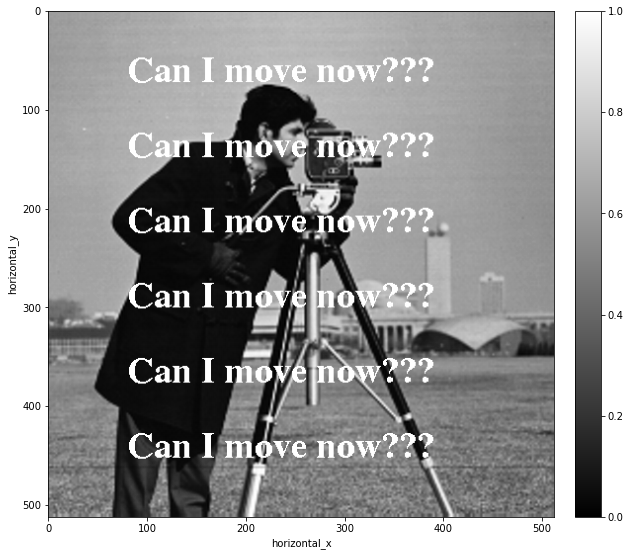

In [2]:
# Load Rainbow data
data = dataexample.CAMERA.get()
ig = data.geometry
im = data.array

# Create inpainted image using Pillow
tmp = Image.fromarray(im)
text = "\n         Can I move now???          \n "*6
draw = ImageDraw.Draw(tmp)
font = ImageFont.truetype('FreeSerifBold.ttf', 37)
draw.text((0, 0), text, font=font)

im1 = np.array(tmp)
im1 = im1/im1.max()
ig1 = ig.copy()
data1 = ig1.allocate()
data1.fill(im1)
show2D(data1, origin="upper")

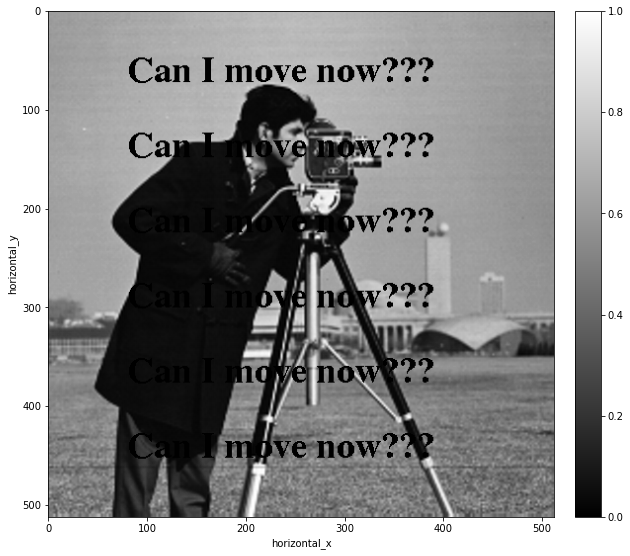

In [3]:
# Create mask from corrupted image and apply MaskOperator channelwise
tmp_mask_array = np.abs(im1 - im)
mask2D = ((data1-data).abs()==0)

mask = ig.allocate()
mask.fill(mask2D)
MO = MaskOperator(mask)

# Create missing data image
missing_data = MO.direct(data1) 
show2D(missing_data, origin="upper")

In [5]:
# Setup and run the ADMM algorithm
alpha = 0.05

G = BlockFunction(alpha*MixedL21Norm(), L2NormSquared(b=missing_data))
F = ZeroFunction()
K = BlockOperator(GradientOperator(ig), MO)

normK = K.norm()

sigma = 1.
tau = sigma/normK**2

admm = LADMM(f=F, g=G, operator=K, max_iteration=2000, update_objective_interval=500)
admm.run(1000,verbose=1)

Initialised GradientOperator with C backend running with  20  threads
LADMM setting up
LADMM configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          6.86408e+04


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      500       2000         0.013          2.71645e+02
     1000       2000         0.013          2.71579e+02
-------------------------------------------------------
     1000       2000         0.013          2.71579e+02
Stop criterion has been reached.



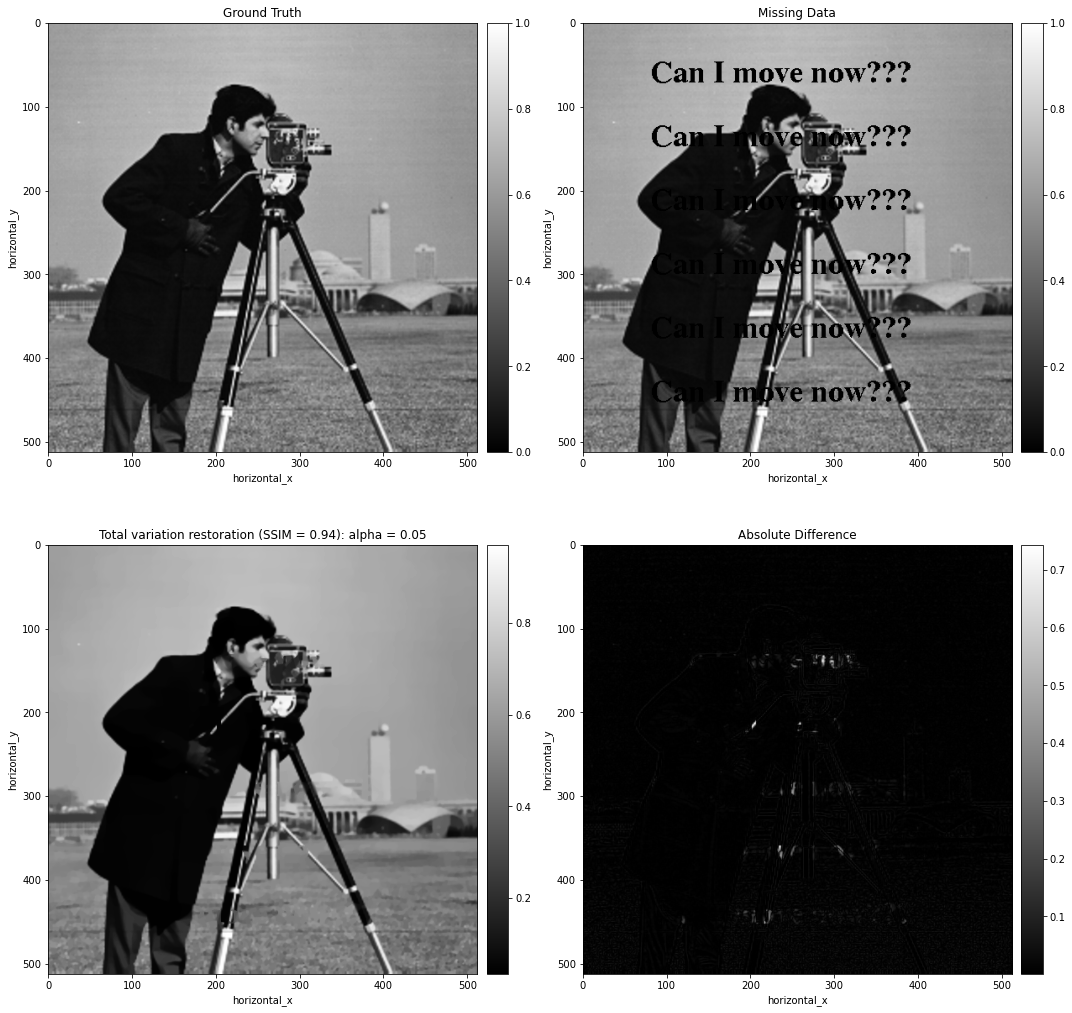

In [6]:
val_ssim = ssim(data.as_array(), admm.solution.as_array(), data_range = 1.)

show2D([data, missing_data, admm.solution, (admm.solution-data).abs()],
      title=["Ground Truth", 
              "Missing Data", 
              "Total variation restoration (SSIM = {:.2f}): alpha = {}".format(val_ssim, alpha),
              "Absolute Difference"],
     origin = "upper")